<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/ForConsistency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Investigation of Tanh activation function](#scrollTo=Db4dvLsLU0UY)

>[Data Augmentation](#scrollTo=Db4dvLsLU0UY)

>[Creating training and testing data set for loading and preprocessing the images](#scrollTo=ZP8zGYwkUv6z)

>[Building and training the model](#scrollTo=hrWYKmiEVr4S)

>[Evalutating the model on test data](#scrollTo=dQ9sN6o4fVEc)

>[Plot training history](#scrollTo=Uu83BmTBftLA)






# Investigation of Tanh activation function

...

# 1. Data Augmentation   

...

In [2]:
from pathlib import Path  # Import pathlib to work with paths
import kagglehub
import os  # Import os module for file operations
import hashlib
import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# Convert path to a Path object
path = Path(path)

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust these labels based on your dataset's folder names

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


# 2. Creating training and testing data set for loading and preprocessing the images   


In this section we aim to use the function __ImageDataGenerator()__ as a means to preprocess the images in both the training and testing folders of the Brain MRI folder. This is done to create changes to images that promotes randomness and allows the model to generalise better on the available data and also on unseen data while testing.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from pathlib import Path
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix

# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0  # Randomly shift RGB channels (intensity)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# 3. Building and training the model   
We use __Convlolution Neural Networks(CNN)__ with the __Tanh activation function__ on multiple input layers and __softmax__ function on the output layer for 4 classes. Model compiling takes place with the __Adamx__ optimiser using the loss function as __categorical_crossentropy__ for a multi-class classificaton model consisting of mutliple output layers.

In [10]:
# Build CNN model
model = Sequential([
    Conv2D(1024, kernel_size=(3, 3), activation='tanh', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='tanh'),
    Conv2D(128, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),

    Dense(4, activation='softmax')
])
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,  # Increased epochs to get better training results
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)



Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step - accuracy: 0.2873 - loss: 1.4427 - val_accuracy: 0.4617 - val_loss: 1.2213
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3438 - loss: 1.3371 - val_accuracy: 0.0000e+00 - val_loss: 1.5045
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - accuracy: 0.3622 - loss: 1.3022 - val_accuracy: 0.4344 - val_loss: 1.2038
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - accuracy: 0.4375 - loss: 1.2424 - val_accuracy: 0.0000e+00 - val_loss: 1.3214
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.3609 - loss: 1.2826 - val_accuracy: 0.4617 - val_loss: 1.1780
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4375 - loss: 1.0814 - val_accuracy: 0.0323 - val_loss: 1.3264
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.3596 - loss: 1.3011 - val_accuracy: 0.4125 - val_loss: 1.1880
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6562 -

# 4. Evalutating the model on test data   
The test and train accuracy and loss are calucalted to inference on the capability of the neural network model on the given set of images.


In [11]:
train_score = model.evaluate(train_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.9111 - loss: 0.2404
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.8525 - loss: 0.4178
Train Loss:  0.2365209311246872
Train Accuracy:  0.9122899174690247
--------------------
--------------------
Test Loss:  0.31022515892982483
Test Accuracy:  0.8886346220970154


# 5. Plot training history


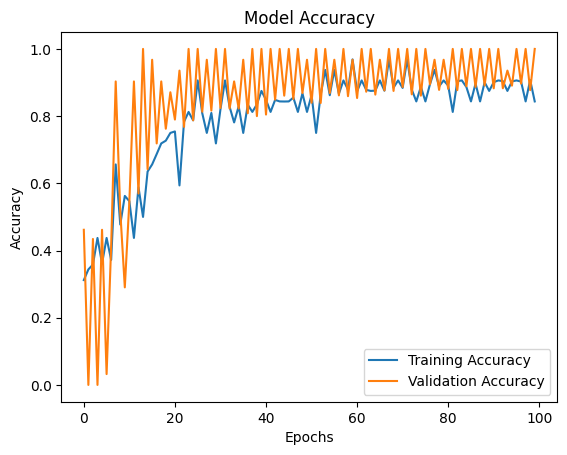

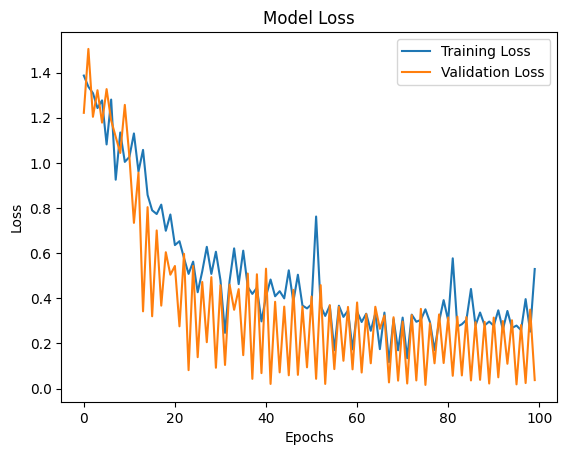

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted class is: meningioma
The probability for the predicted class is: 0.99


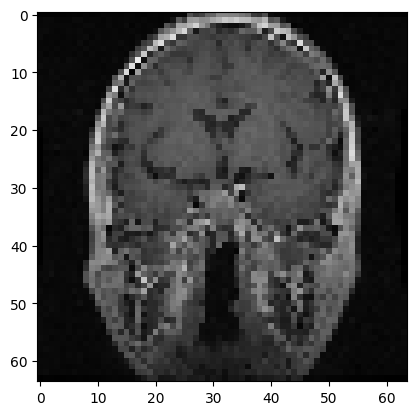

In [23]:
from tensorflow import keras

img = keras.utils.load_img(
    '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0239.jpg', target_size=(64,64)
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions[0])

predicted_class = LABELS[predicted_class_index]



score = predictions[0][predicted_class_index]
print(f"The predicted class is: {predicted_class}")
print(f"The probability for the predicted class is: {score:.2f}")
